## 0. Dependency Libraries 

In [1]:
import os
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy.stats import ttest_ind
from sklearn.metrics import confusion_matrix

In [2]:
# Read the original dataset
data_dir = ''
file_path = 'screening_exercise_orders_v201810.csv'
ori_data = pd.read_csv(os.path.join(data_dir, file_path), header = 0)
ori_data.head(10)

,customer_id,gender,date,value,predicted_gender
0,1000,0,2017-01-01 00:11:31,198.50,1
1,1001,0,2017-01-01 00:29:56,338.00,1
2,1002,1,2017-01-01 01:30:31,733.00,1
3,1003,1,2017-01-01 01:34:22,772.00,1
4,1004,0,2017-01-01 03:11:54,508.00,1
5,1005,1,2017-01-01 10:08:05,338.00,0
6,1006,1,2017-01-01 15:42:57,1526.43,1
7,1007,0,2017-01-01 15:59:50,168.00,0
8,1008,0,2017-01-01 18:01:04,207.99,0
9,1009,1,2017-01-01 19:27:17,283.00,1


In [3]:
# check the length first
print("Original dataset length: "+str(len(ori_data)))

Original dataset length: 13471


## A) Assemble a dataframe with one row per customer and the following columns:
#### * customer_id * gender * most_recent_order_date * order_count (number of orders placed by this customer)
#### Sort the dataframe by customer_id ascending and display the first 10 rows.

In [4]:
## Group rows by using customer_id and gender, and find the most_recent_order_date for each customer
## Since 'customer_id' in the original dataset is already sorted in ascending, there is no need to resort, turn off the sort function could increase the performance.
customer_data = pd.DataFrame(ori_data.groupby(['customer_id', 'gender'], sort=False)['date'].max()).rename(columns={'date':'most_recent_order_date'})
customer_data.sample(3)

,,most_recent_order_date
customer_id,gender,
1667,0,2017-02-11 18:20:32
4726,1,2017-05-17 14:18:47
9339,1,2017-12-12 17:35:28


In [5]:
## check the length after grouping
print("Customer dataset length: "+str(len(customer_data)))

Customer dataset length: 8814


In [6]:
## Add order_count for each customer
## After count values, sort the Series data by index to match the order in customer_data
customer_data['order_count'] = ori_data['customer_id'].value_counts().sort_index().values
customer_data.sample(3)

,,most_recent_order_date,order_count
customer_id,gender,,
5660,1,2017-06-21 13:52:45,1
1395,0,2017-01-14 21:25:54,1
2376,1,2017-02-16 19:26:40,1


In [7]:
# Sort the dataframe by customer_id ascending and display the first 10 rows.
customer_data.head(10)

,,most_recent_order_date,order_count
customer_id,gender,,
1000,0,2017-01-01 00:11:31,1
1001,0,2017-01-01 00:29:56,1
1002,1,2017-02-19 21:35:31,3
1003,1,2017-04-26 02:37:20,4
1004,0,2017-01-01 03:11:54,1
1005,1,2017-12-16 01:39:27,2
1006,1,2017-05-09 15:27:20,3
1007,0,2017-01-01 15:59:50,1
1008,0,2017-12-17 05:47:48,3


## B) Plot the count of orders per week for the store.

In [8]:
## Since we want to count orders by week, I check the type of column 'date' first, and I found that is not suitable for datatime
ori_data.dtypes

customer_id           int64
gender                int64
date                 object
value               float64
predicted_gender      int64
dtype: object

In [9]:
## Since we only want to plot orders per week, I just take the date and count up each row as one order (Because we do not exclude $0 order).
countByWeek_data = pd.concat([ori_data['date'], pd.DataFrame(index = range(len(ori_data)), columns = ['count']).fillna(1)], axis=1)
## Change the type 'date' to datetime
countByWeek_data['date'] = pd.to_datetime(countByWeek_data['date'])
countByWeek_data.sample(3)

,date,count
10334,2017-10-06 05:36:55,1
1978,2017-02-24 16:04:19,1
8760,2017-08-15 22:07:47,1


In [10]:
## Now we got the right type for date
countByWeek_data.dtypes

date     datetime64[ns]
count             int64
dtype: object

In [11]:
## Remap the complex date format to 'days'.
countByWeek_data['date'] = countByWeek_data['date'].apply(lambda x : datetime.datetime(year=x.year, month=x.month, day=x.day))
## Set date as the index
countByWeek_data.set_index(countByWeek_data['date'],inplace=True)
countByWeek_data.sample(3)

,date,count
date,,
2017-09-12,2017-09-12,1
2017-05-12,2017-05-12,1
2017-03-03,2017-03-03,1


In [12]:
## Then resample the data by weeks
countByWeek_data = countByWeek_data.resample('W').sum()
countByWeek_data.head(10)

,count
date,
2017-01-01,14
2017-01-08,180
2017-01-15,264
2017-01-22,405
2017-01-29,233
2017-02-05,211
2017-02-12,195
2017-02-19,248
2017-02-26,315


In [13]:
## Check the length to make sure I don't lose any rows.
assert int(countByWeek_data.sum()) == len(ori_data), "Lost rows!"

In [14]:
# Convert index from datetime to string for a better looking in bar plot.
countByWeek_data.set_index(countByWeek_data.index.strftime('%m/%d/%Y').values, inplace=True)

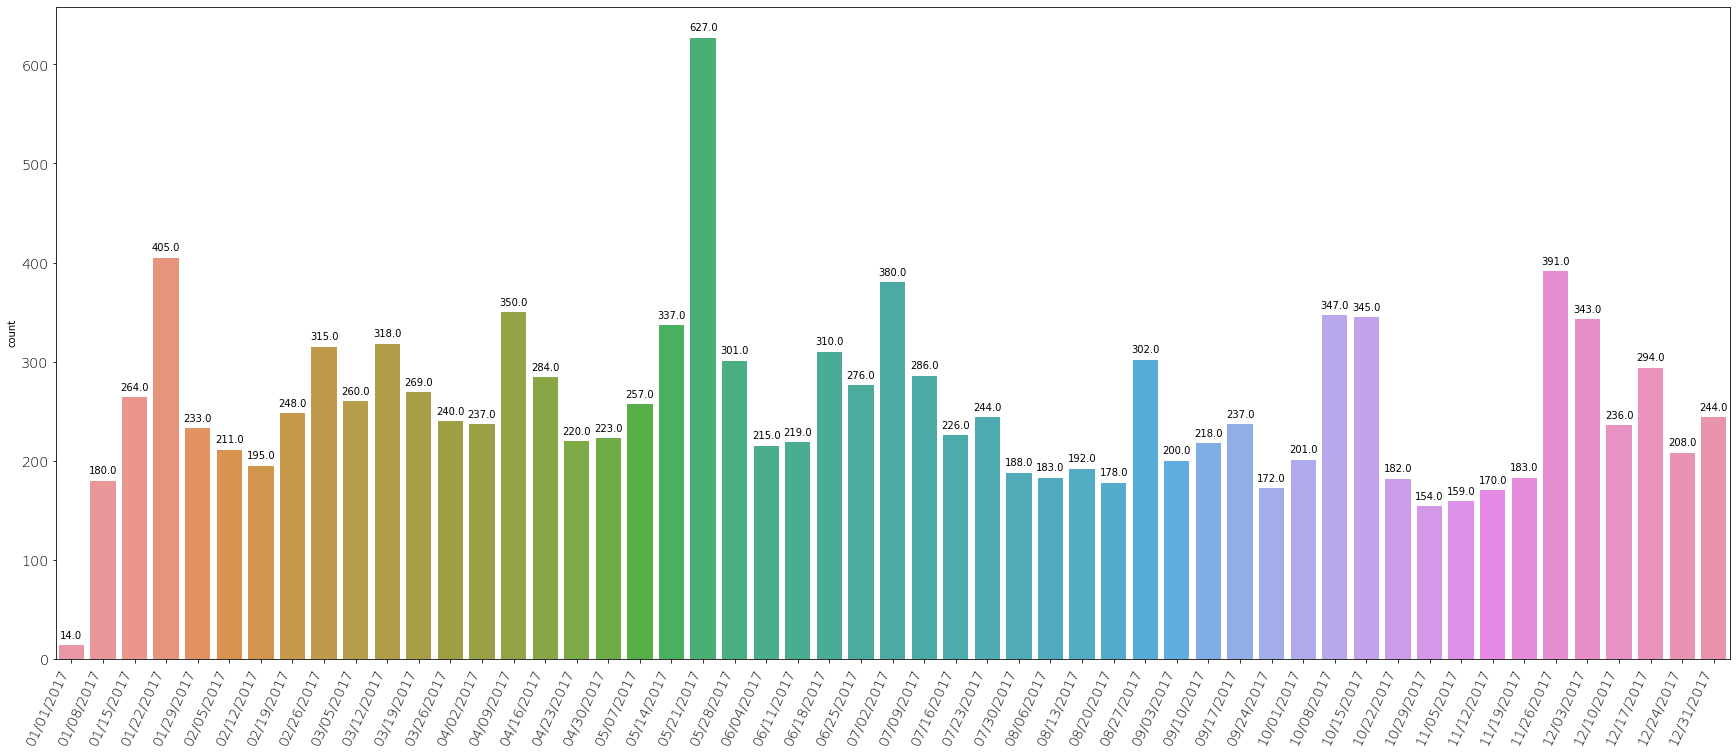

In [15]:
plt.figure(figsize=(30,12))
ax = sns.barplot(x=countByWeek_data.index, y=countByWeek_data['count'])
plt.xticks(rotation=65,
           horizontalalignment='right',
           fontweight='light',
           fontsize='x-large'  )
plt.yticks(fontweight='light',
           fontsize='x-large')
for p in ax.patches: ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

## C) Compute the mean order value for gender 0 and for gender 1. Do you think the difference is significant? Justify your choice of method.

In [16]:
mean_gender = ori_data.groupby(['gender'], sort=False)['value'].mean()
gender_0_mean = round(mean_gender[0], 2)
gender_1_mean = round(mean_gender[1], 2)
print("The MEAN order value made by gender 0: " + str(gender_0_mean))
print("The MEAN order value made by gender 1: " + str(gender_1_mean))

The MEAN order value made by gender 0: 363.89
The MEAN order value made by gender 1: 350.71


In [17]:
## My first idea among these two genders is that the difference is very limited, from population variance to the total value.
## In order to justify this opinion, I would use the 2 tailed T-test.

## Null Hypothesis: The mean order values made by two genders are equal.
## Alternative Hypothesis: The mean order values made by two genders are NOT equal.
## Significance Value: 5%

In [18]:
## Before I do the 2 tailed test, I would like to get an overall view of sample sizes and variances.
gender_1_count = ori_data['gender'].sum()
gender_0_count = len(ori_data) - gender_1_count
print("The number of orders made by gender 0: " + str(gender_0_count))
print("The number of orders made by gender 1: " + str(gender_1_count))
var_gender = ori_data.groupby(['gender'], sort=False)['value'].std()
print("The standard deviation of order value made by gender 0: " + str(var_gender[0]))
print("The standard deviation of order value made by gender 1: " + str(var_gender[1]))

The number of orders made by gender 0: 6759
The number of orders made by gender 1: 6712
The standard deviation of order value made by gender 0: 396.53321516246115
The standard deviation of order value made by gender 1: 377.50473748671084


In [19]:
## Since I got different sample sizes and variances, I would like to use Welch's test.
ttest_ind(ori_data.loc[ori_data['gender']==0]['value'], ori_data.loc[ori_data['gender']==1]['value'], equal_var=False)

Ttest_indResult(statistic=1.976107933576866, pvalue=0.04816296295128402)

In [20]:
## The pvalue = 0.04816296295128402 which is less than my significant value 5%. 
## Therefore, I would take Alternative Hypothesis rather than Null Hypothesis.
## The mean order values made by two genders are NOT equal.

## D) Generate a confusion matrix for the gender predictions of customers in this dataset. You should assume that there is only one gender prediction for each customer. What does the confusion matrix tell you about the quality of the predictions?

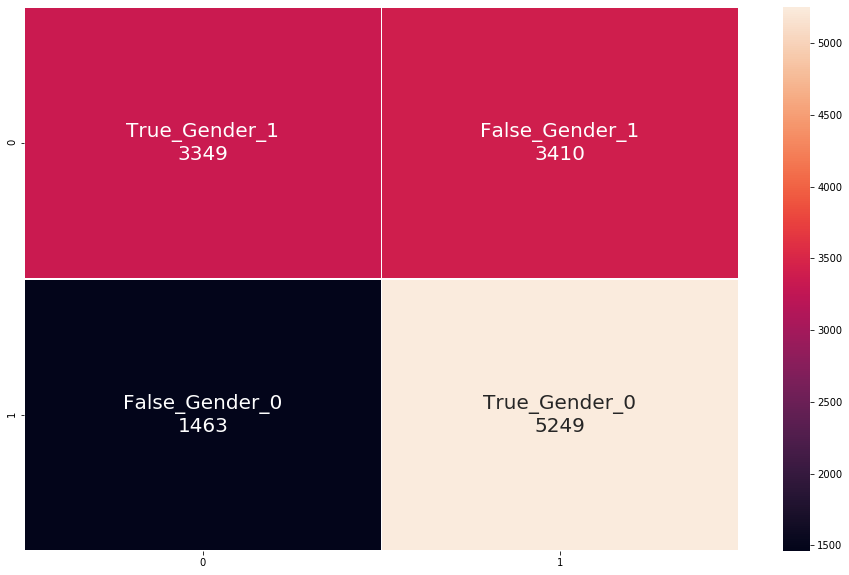

In [21]:
tn, fp, fn, tp = confusion_matrix(ori_data['gender'], ori_data['predicted_gender']).ravel()
plt.figure(figsize = (16,10))
labels=np.array([['True_Gender_1\n'+str(tn), 'False_Gender_1\n'+str(fp)], ['False_Gender_0\n'+str(fn), 'True_Gender_0\n'+str(tp)]])
sns.heatmap(pd.DataFrame(confusion_matrix(ori_data['gender'], ori_data['predicted_gender'])), 
            annot=labels, fmt='', linewidth=0.5, annot_kws={'size':20})

In [22]:
## Accuracy
accuracy = (tp + tn)/(tn + fp + fn + tp)
print("Accuracy: " + str(accuracy))

## Precision
precision = tp / (tp + fp)
print("Precision: " + str(precision))

## Recall (Sensitivity)
recall = tp / (tp + fn)
print("Recall: " + str(recall))

## Specificity
specificity = tn / (tn + fp)
print("Specificity: " + str(specificity))

## F1 score
f1 = 2 * (recall * precision) / (recall + precision)
print("F1 Score: " + str(f1))

Accuracy: 0.6382599658525722
Precision: 0.6061900912345537
Recall: 0.7820321811680572
Specificity: 0.495487498150614
F1 Score: 0.6829744323726498


In [23]:
## As the result above, I can see a huge difference between recall and specificity 
##     which indicates the current model predicts gender 1 much better than gender 0.
## If the model is used to predict(or recommend) business(or merchandise) for gender 1, 
##     and we don't care about the wrong push for gender 0, we want to find and send recommendations to gender 1 as much as possible,
##     I would say the current model made a decent job (if the current recall is the highest we can get).
## Otherwise, the current model has a huge bias and must to fixed immediately. 

## Second, according to the difference between precision and recall, I think there is still has some room for improvement of the F1 score.
## If we want a more balanced model, try different threshold settings to get a higher F1 score.

## E) Describe one of your favorite tools or techniques and give a small example of how it's helped you solve a problem. Limit your answer to one paragraph, and please be specific.

In [25]:
## My favorite tool is Sagemaker. It is a very powerful tool for machine learning engineer. 
## Not only can we use AWS online computing resources, but also we could easily interact with our model. Especially for the ML model, because we need to adjust hyperparameters many times.
## I would like to show a simple case that Sagemaker helps me to tune my model and find the best for me by using HyperparameterTuner.

In [ ]:
## Let's say we finished preprocessing data and successfully extracted the proper features for modeling.
## And then we separated them into train, validation, and test datasets.
data_dir = ''
train_data = 'xxx.csv'
valid_data = 'xxx.csv'
test_data = 'xxx.csv'

## Then we upload them to S3 in order to access directly by Sagemaker
import sagemaker
session = sagemaker.Session()
prefix = 'screening-test'
test_location = session.upload_data(os.path.join(data_dir, test_data), key_prefix=prefix)
val_location = session.upload_data(os.path.join(data_dir, valid_data), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, train_data), key_prefix=prefix)

In [ ]:
from sagemaker import get_execution_role
role = get_execution_role()
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(session.boto_region_name, 'xgboost')

## Create ML model
xgb = sagemaker.estimator.Estimator(container,
                                    role,
                                    train_instance_count=1,
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                    sagemaker_session=session)
## And then set an initial hyperparameter
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        early_stopping_rounds=10,
                        num_round=500)

## Create the hyperparameter tuner
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner
xgb_hyperparameter_tuner = HyperparameterTuner(estimator = xgb,
                                               objective_metric_name = 'validation:rmse',
                                               objective_type = 'Minimize',
                                               max_jobs = 6,
                                               max_parallel_jobs = 3,
                                               hyperparameter_ranges = {
                                                    'max_depth': IntegerParameter(3, 12),
                                                    'eta'      : ContinuousParameter(0.05, 0.5),
                                                    'min_child_weight': IntegerParameter(2, 8),
                                                    'subsample': ContinuousParameter(0.5, 0.9),
                                                    'gamma': ContinuousParameter(0, 10),
                                               })

In [ ]:
## Fit the hyperparameter tuner
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=val_location, content_type='csv')
xgb_hyperparameter_tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})
xgb_hyperparameter_tuner.wait()

In [ ]:
## Since I don't have real data to train, I paste some logs from my elder model.

Name Status Objective metric value Creation time Training Duration

sagemaker-xgboost-200720-0250-020-d3493ac5	Completed 0.31255999207496643	Jul 20, 2020 03:45 UTC	6 minute(s)

sagemaker-xgboost-200720-0250-019-333013a9	Completed 0.31870999932289124	Jul 20, 2020 03:42 UTC	4 minute(s)

sagemaker-xgboost-200720-0250-018-7b9b2b42	Completed 0.32662999629974365	Jul 20, 2020 03:40 UTC	9 minute(s)

sagemaker-xgboost-200720-0250-017-cf1f871e	Completed 0.31321001052856445	Jul 20, 2020 03:36 UTC	4 minute(s)

sagemaker-xgboost-200720-0250-016-9f335187	Completed 0.3133000135421753	Jul 20, 2020 03:34 UTC	9 minute(s)

sagemaker-xgboost-200720-0250-015-02a7ceb5	Completed 0.32071998715400696	Jul 20, 2020 03:32 UTC	6 minute(s)

sagemaker-xgboost-200720-0250-014-77492d0f	Completed 0.3159399926662445	Jul 20, 2020 03:26 UTC	7 minute(s)

sagemaker-xgboost-200720-0250-013-74bd4033	Completed 0.31652000546455383	Jul 20, 2020 03:23 UTC	6 minute(s)

sagemaker-xgboost-200720-0250-012-ee9a08e4	Completed 0.3098300099372864	Jul 20, 2020 03:23 UTC	8 minute(s)

sagemaker-xgboost-200720-0250-011-e49454d7	Completed 0.31707000732421875	Jul 20, 2020 03:15 UTC	7 minute(s)